In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from collections import Counter
import math
import sys
from matplotlib.gridspec import GridSpec

In [2]:
barList = ['ridge','hip','rafter']
algorithmList = ['Best Fit Decreasing','Random Search','Simulated Annealing']
wasteLimit = {'ridge':350,'hip':1000,'rafter':1000}

In [3]:
Res = pd.read_csv('all_algorithms_Results_RW.csv')
del Res['Unnamed: 0']
Res

,BarType,Seed,Algorithm,Iteration,Objective,Iteration_sec,Results
0,ridge,0,Best Fit Decreasing,0,3232.9,0.000700,"[[5000, 24, [1750, 1750, 1500], 0], [5000, 24,..."
1,ridge,0,Best Fit Decreasing,1,3232.9,0.000729,"[[5000, 24, [1750, 1750, 1500], 0], [5000, 24,..."
2,ridge,0,Best Fit Decreasing,2,3232.9,0.000734,"[[5000, 24, [1750, 1750, 1500], 0], [5000, 24,..."
3,ridge,0,Best Fit Decreasing,3,3232.9,0.000724,"[[5000, 24, [1750, 1750, 1500], 0], [5000, 24,..."
4,ridge,0,Best Fit Decreasing,4,3232.9,0.000712,"[[5000, 24, [1750, 1750, 1500], 0], [5000, 24,..."
...,...,...,...,...,...,...,...
89995,rafter,19,Simulated Annealing,495,68190.6,0.007993,"[[7000, 23, [847, 1078, 1864, 913, 1885], 413]..."
89996,rafter,19,Simulated Annealing,496,68190.6,0.005372,"[[7000, 23, [847, 1078, 1864, 913, 1885], 413]..."
89997,rafter,19,Simulated Annealing,497,68190.6,0.007308,"[[7000, 23, [847, 1078, 1864, 913, 1885], 413]..."
89998,rafter,19,Simulated Annealing,498,68190.6,0.007154,"[[7000, 23, [847, 1078, 1864, 913, 1885], 413]..."


In [4]:
#this convert result from list to df
def resultDF(result,waste):
    stockSize,stockPrice,cuttingPatterns,Leftover,Wastage,stockLeft = [],[],[],[],[],[]
    
    for k in result:
        stockSize.append(k[0])
        stockPrice.append(k[1])
        cuttingPatterns.append(k[2])
        l = k[3]
        Leftover.append(l)
        if l < waste and l>0:
            Wastage.append(l)
            stockLeft.append(0)
        else:
            Wastage.append(0)
            stockLeft.append(l)
    dic1 = {'stockSize': stockSize,'stockPrice': stockPrice,'Leftover': Leftover,
            'wastage':Wastage,'stockLeft':stockLeft,'cuttingPatterns': cuttingPatterns} 
    df = pd.DataFrame(dic1)
    
    return df

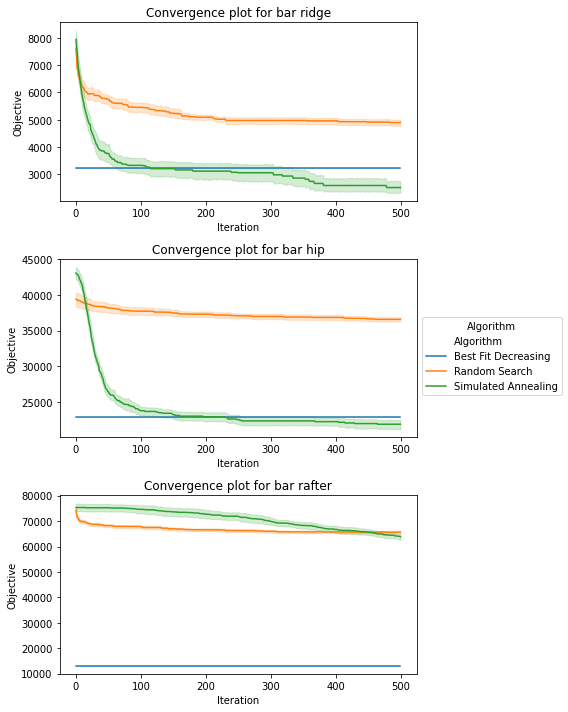

In [5]:
#plot the convergence situation of each algorithm
def convergence_plot(df):    
    fig, ax = plt.subplots(3,1,figsize=(8,10))
    b1 = sns.lineplot(x="Iteration", y="Objective",hue="Algorithm", data=df[df['BarType']== 'ridge'],ax=ax[0])
    b1.set_title('Convergence plot for bar ridge')
    b1.legend_.remove()

    b2 = sns.lineplot(x="Iteration", y="Objective",hue="Algorithm", data=df[df['BarType']== 'hip'],ax=ax[1])
    b2.set_title('Convergence plot for bar hip')
    b2.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7),title = 'Algorithm')
    

    b3 = sns.lineplot(x="Iteration", y="Objective",hue="Algorithm", data=df[df['BarType']== 'rafter'],ax=ax[2])
    b3.set_title('Convergence plot for bar rafter')
    b3.legend_.remove()
    plt.tight_layout()
convergence_plot(Res)

In [6]:
#visualize the time summary info of each algorithm on each subsets
sumTimeDf = pd.DataFrame({'Time_sec' : Res.groupby(['BarType','Algorithm','Seed'])['Iteration_sec'].apply(lambda x: np.sum(x))}).reset_index()
timeDf = pd.DataFrame({'Max' : sumTimeDf.groupby(['BarType','Algorithm'])['Time_sec'].apply(lambda x: np.max(x)),
                        'Min' : sumTimeDf.groupby(['BarType','Algorithm'])['Time_sec'].apply(lambda x: np.min(x)),
                        'Mean' : sumTimeDf.groupby(['BarType','Algorithm'])['Time_sec'].apply(lambda x: np.mean(x)),
                        'Std' : sumTimeDf.groupby(['BarType','Algorithm'])['Time_sec'].apply(lambda x: np.std(x))}).reset_index()
timeDf

,BarType,Algorithm,Max,Min,Mean,Std
0,hip,Best Fit Decreasing,1.578324,0.458452,0.544456,0.246921
1,hip,Random Search,0.261133,0.232904,0.235858,0.005902
2,hip,Simulated Annealing,12.333579,7.990995,8.785719,1.115447
3,rafter,Best Fit Decreasing,424.853235,412.602800,416.143601,4.074083
4,rafter,Random Search,1.082678,1.058679,1.067781,0.006571
5,rafter,Simulated Annealing,4.072350,2.759229,3.038217,0.301895
6,ridge,Best Fit Decreasing,0.427928,0.257762,0.270551,0.037111
7,ridge,Random Search,0.125306,0.110377,0.112817,0.003278
8,ridge,Simulated Annealing,7.672471,1.268337,2.664933,1.244066


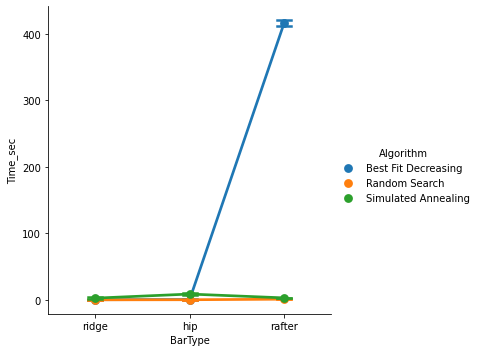

In [7]:
#plot the time performance of each algorithm on each roof member
def algorithms_performance(df):
    newDf = pd.DataFrame({'Time_sec' : df.groupby(['BarType','Algorithm','Seed'])['Iteration_sec'].apply(lambda x: np.sum(x))}).reset_index()
    sns.catplot(x="BarType", y="Time_sec", hue="Algorithm", kind="point", data=newDf,
                ci='sd', errwidth = 2.5, capsize=0.15, order=['ridge','hip','rafter'])
    
algorithms_performance(Res)

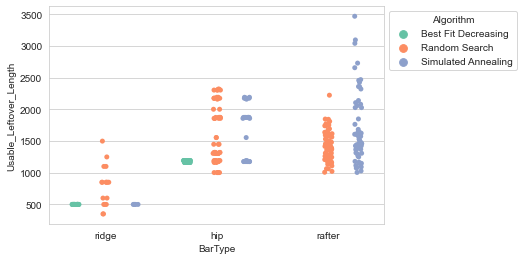

In [8]:
#plot the distribution of the usable leftover on each stock
def usable_stocks_plot(df,wasteLimit):
    
    newDf = pd.DataFrame(columns=['BarType','Algorithm','Usable_Leftover_Length'])
    d = 0
    for barName in barList:
        for algorithm in algorithmList:
            currDf = df[(df['BarType']==barName) & (df['Seed']==1) & (df['Algorithm']==algorithm)]
            currRes = literal_eval(currDf.iloc[-1]['Results'])
            waste = wasteLimit[barName]
            resDf = resultDF(currRes,waste)
            left = list(resDf['stockLeft'])
            usableLeft = list(filter(lambda x:x!=0,left))
            for usableL in usableLeft:
                newDf.loc[d] = [barName,algorithm,usableL]
                d += 1
    sns.set_style("whitegrid")

    ax = sns.stripplot(x="BarType", y="Usable_Leftover_Length", hue="Algorithm",
                   data=newDf, palette="Set2", dodge=True)
    #ax.set_title('Usable leftover length distribution from one seed result')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),title = 'Algorithm')
    plt.show()
    return ax   

usable_stocks_plot(Res,wasteLimit)

In [9]:
#get the details concerning cutting pattern of stock
def cutting_patterns(df):
    newDf = pd.DataFrame(columns=['BarType','Seed','Algorithm','Total_Pattern_Amounts','CuttingPatterns','StockLength','Leftover'])
    n=0
    for barName in barList:
        for se in range(20):
            for algorithm in algorithmList:
                currDf = df[(df['BarType']==barName) & (df['Seed']==se) & (df['Algorithm']==algorithm)]
                currRes = literal_eval(currDf.iloc[-1]['Results'])
                waste = wasteLimit[barName]
                resDf = resultDF(currRes,waste)
                patternDict = {i:[] for i in resDf.stockSize.unique()}
                for row in range(resDf.shape[0]):
                    patternDict[resDf.loc[row,'stockSize']].append(resDf.loc[row,'cuttingPatterns'])
                for stockLength,patternList in patternDict.items():
                    for p in patternList:
                        i = patternList.index(p)
                        patternList[i] = sorted(p)
                    patternList = sorted(patternList)
                    while patternList:
                        curPattern = patternList[0]
                        amount = 0
                        l = len(patternList)
                        i = 0
                        while i<=l:
                            if patternList[i] == curPattern:
                                amount += 1
                                patternList.remove(patternList[i])
                            else:
                                break
                            if len(patternList) == 0:
                                break
                        left = stockLength - sum(curPattern)
                        newDf.loc[n] = [barName,se,algorithm,amount,curPattern,stockLength,left]
                        n += 1
    return newDf

cp = cutting_patterns(Res)   
cp.to_csv('cutting_patterns.csv')
cp

,BarType,Seed,Algorithm,Total_Pattern_Amounts,CuttingPatterns,StockLength,Leftover
0,ridge,0,Best Fit Decreasing,3,"[900, 900, 900, 900, 900]",5000,500
1,ridge,0,Best Fit Decreasing,1,"[900, 900, 1500, 1500]",5000,200
2,ridge,0,Best Fit Decreasing,16,"[1500, 1500, 1500]",5000,500
3,ridge,0,Best Fit Decreasing,10,"[1500, 1750, 1750]",5000,0
4,ridge,0,Best Fit Decreasing,1,"[900, 900, 900]",3000,300
...,...,...,...,...,...,...,...
12545,rafter,19,Simulated Annealing,1,"[1830, 1996, 1996]",6000,178
12546,rafter,19,Simulated Annealing,1,"[1864, 1864, 1864]",6000,408
12547,rafter,19,Simulated Annealing,1,"[1864, 1864, 1996]",6000,276
12548,rafter,19,Simulated Annealing,1,"[1864, 1996, 2029]",6000,111


In [10]:
pdf = pd.read_csv('cutting_patterns.csv')
pdf['SumStock'] = ''
pdf['SumLeft'] = ''
for i in range(pdf.shape[0]):
    pdf.loc[i,'SumStock'] =  pdf.loc[i,'Total_Pattern_Amounts'] * pdf.loc[i,'StockLength'] 
    pdf.loc[i,'SumLeft'] =  pdf.loc[i,'Total_Pattern_Amounts'] * pdf.loc[i,'Leftover'] 

del pdf['Unnamed: 0']
pdf

,BarType,Seed,Algorithm,Total_Pattern_Amounts,CuttingPatterns,StockLength,Leftover,SumStock,SumLeft
0,ridge,0,Best Fit Decreasing,3,"[900, 900, 900, 900, 900]",5000,500,15000,1500
1,ridge,0,Best Fit Decreasing,1,"[900, 900, 1500, 1500]",5000,200,5000,200
2,ridge,0,Best Fit Decreasing,16,"[1500, 1500, 1500]",5000,500,80000,8000
3,ridge,0,Best Fit Decreasing,10,"[1500, 1750, 1750]",5000,0,50000,0
4,ridge,0,Best Fit Decreasing,1,"[900, 900, 900]",3000,300,3000,300
...,...,...,...,...,...,...,...,...,...
12545,rafter,19,Simulated Annealing,1,"[1830, 1996, 1996]",6000,178,6000,178
12546,rafter,19,Simulated Annealing,1,"[1864, 1864, 1864]",6000,408,6000,408
12547,rafter,19,Simulated Annealing,1,"[1864, 1864, 1996]",6000,276,6000,276
12548,rafter,19,Simulated Annealing,1,"[1864, 1996, 2029]",6000,111,6000,111


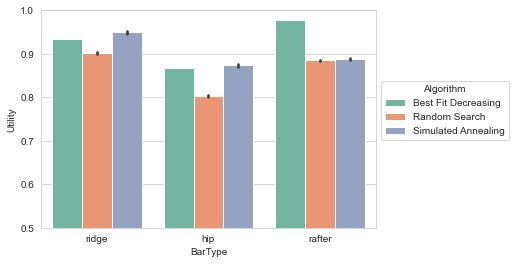

In [11]:
#plot the stocks utility of each algorithms on subsets
def utility_plot(df):
    udf = pd.DataFrame(columns=['BarType','Algorithm','Seed','Utility'])
    df1 = pd.DataFrame({'Total Length' : df.groupby(['BarType','Algorithm','Seed'])['SumStock'].apply(lambda x: np.sum(x))}).reset_index()
    df2 = pd.DataFrame({'Total Leftover' : df.groupby(['BarType','Algorithm','Seed'])['SumLeft'].apply(lambda x: np.sum(x))}).reset_index()
    newdf = df1.merge(df2)
    for i in range(newdf.shape[0]):
        utility = (newdf.loc[i,'Total Length']-newdf.loc[i,'Total Leftover']) / newdf.loc[i,'Total Length']
        udf.loc[i] = [newdf.loc[i,'BarType'],newdf.loc[i,'Algorithm'],newdf.loc[i,'Seed'],utility]
    ax = sns.barplot(x="BarType", y="Utility",hue="Algorithm", data=udf,palette="Set2", order=['ridge','hip','rafter'])
    ax.set_ylim(0.5,1)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7),title = 'Algorithm')

utility_plot(pdf)

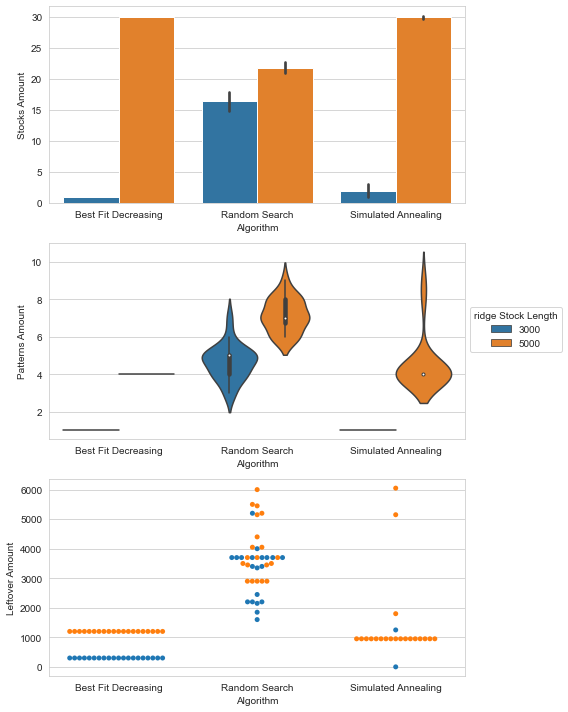

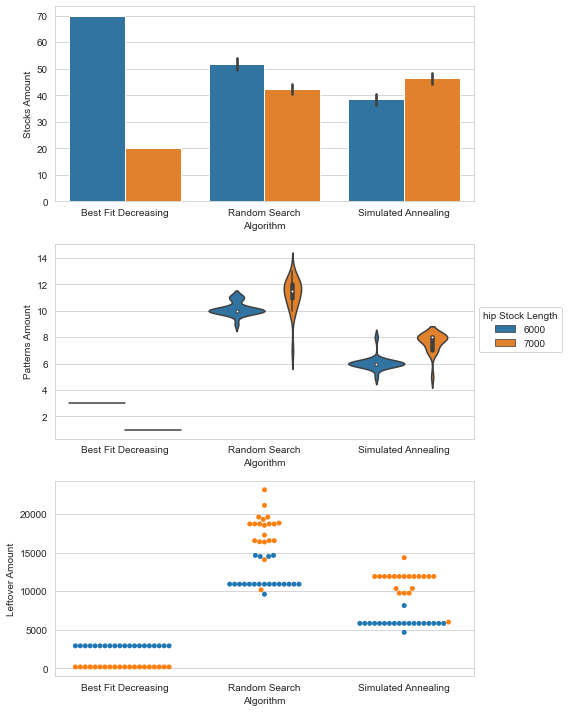

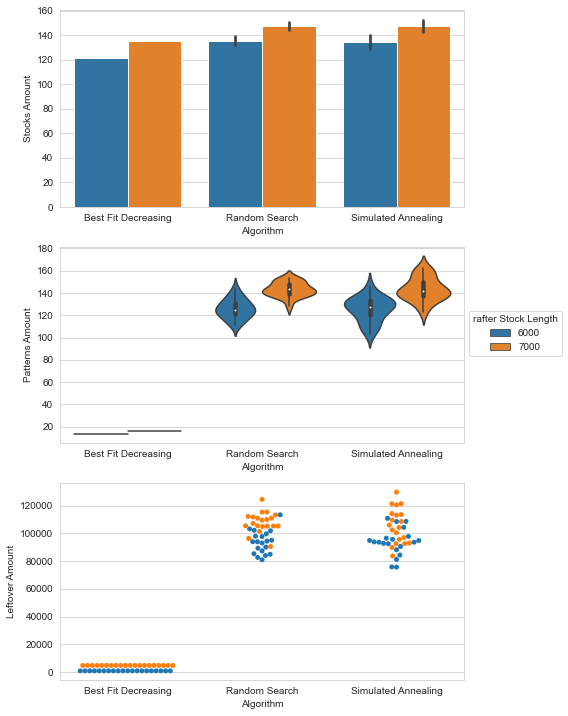

In [12]:
#plot the info around cutting pattern
def patterns_result(df):
    df_pa = pd.DataFrame({'Patterns Amount' : df.groupby(['BarType','Algorithm','Seed','StockLength'])['StockLength'].apply(lambda x: len(x))}).reset_index()
    df_sa = pd.DataFrame({'Stocks Amount' : df.groupby(['BarType','Algorithm','Seed','StockLength'])['Total_Pattern_Amounts'].apply(lambda x: np.sum(x))}).reset_index()
    newdf = df_pa.merge(df_sa)
    df_left = pd.DataFrame({'Leftover Amount' : df.groupby(['BarType','Algorithm','Seed','StockLength'])['Leftover'].apply(lambda x: np.sum(x))}).reset_index()
    newdf = newdf.merge(df_left)

    for barName in barList:
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(3,1,figsize=(8,10))
        subdf = newdf[newdf['BarType'] == barName]
        b1 = sns.barplot(x="Algorithm", y="Stocks Amount", hue="StockLength", data=subdf,ax=ax[0])
        b1.legend_.remove()
        v1 = sns.violinplot(x="Algorithm", y="Patterns Amount", hue="StockLength", data=subdf,ax=ax[1])
        v1.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7),title = barName+' Stock Length')
        s1 = sns.swarmplot(x="Algorithm", y="Leftover Amount", hue="StockLength", data=subdf,ax=ax[2])
        s1.legend_.remove()
        plt.tight_layout()

patterns_result(pdf)

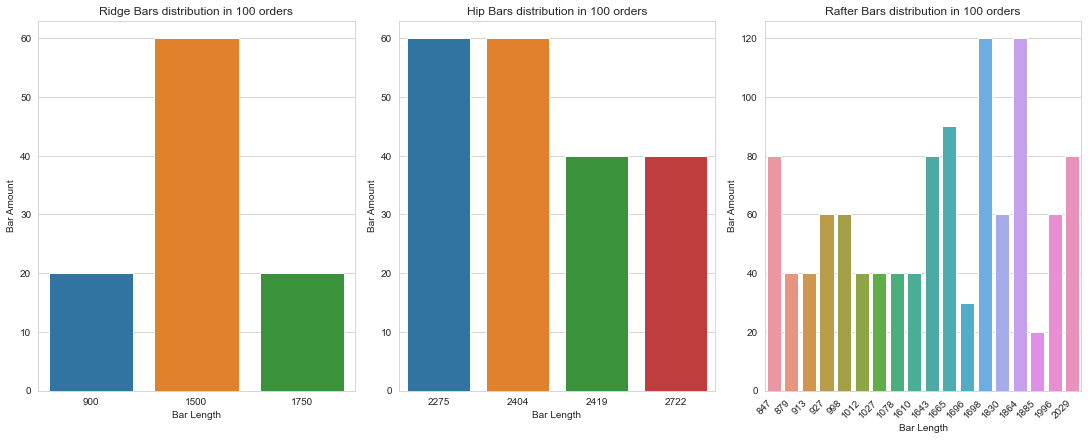

In [13]:
#conclude the number of bars of each roof member
def bars_amount_plot(df):
    barDf = pd.DataFrame(columns=['barName','Bar Length','Bar Amount'])
    b = 0
    for barName in barList:
        sdf = df[(df['BarType']==barName) & (df['Algorithm'] == 'Best Fit Decreasing') & (df['Seed']==10)][['Total_Pattern_Amounts','CuttingPatterns']].reset_index(drop=True)
        bars = []
        for i in range(sdf.shape[0]):
            curPattern = literal_eval(sdf.loc[i,'CuttingPatterns'])
            bars += (curPattern * sdf.loc[i,'Total_Pattern_Amounts'])
        curBarList = dict(Counter(bars))
        for key,value in curBarList.items():
            barDf.loc[b] = [barName,key,value]
            b+=1
    
    fig = plt.figure(constrained_layout=True,figsize=(15,6))
    gs = GridSpec(1, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    sns.barplot(x="Bar Length", y="Bar Amount", data=barDf[barDf['barName'] =='ridge'],ax =ax1)
    ax1.set_title('Ridge Bars distribution in 100 orders')
    sns.barplot(x="Bar Length", y="Bar Amount", data=barDf[barDf['barName'] =='hip'],ax =ax2)
    ax2.set_title('Hip Bars distribution in 100 orders')
    sns.barplot(x="Bar Length", y="Bar Amount", data=barDf[barDf['barName'] =='rafter'],ax =ax3)
    plt.setp(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax3.set_title('Rafter Bars distribution in 100 orders')
    
bars_amount_plot(pdf)    

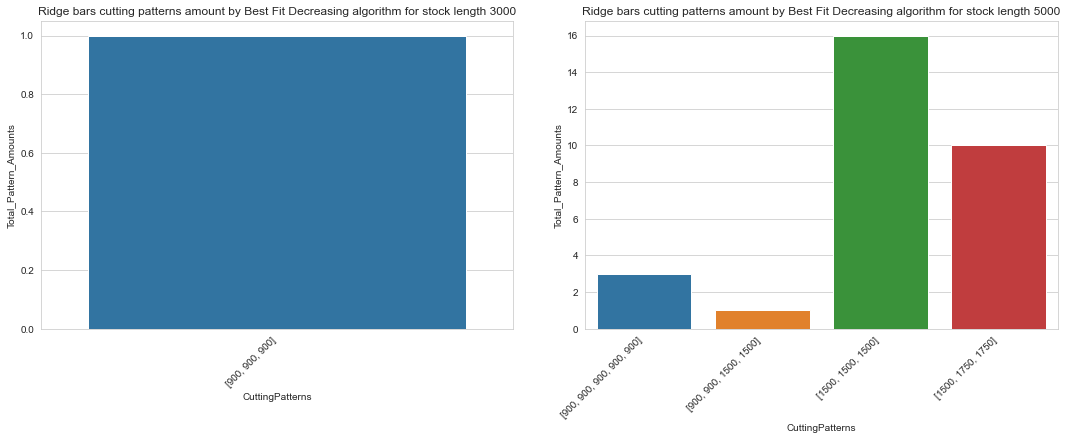

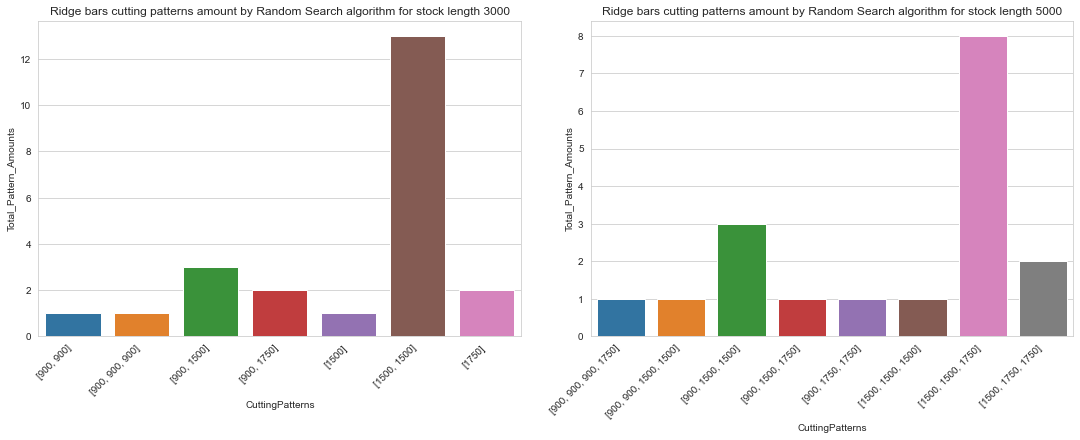

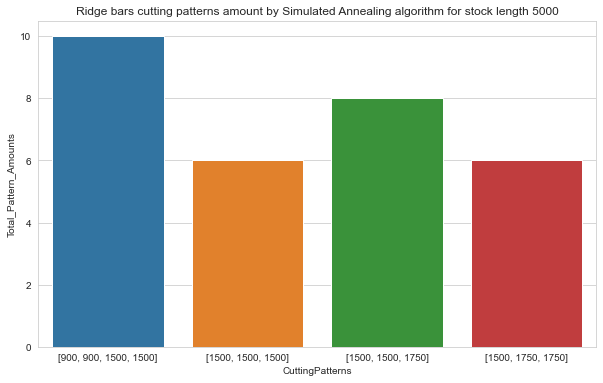

In [14]:
#Ridge bar cutting patterns
for algorithm in algorithmList:
    newdf = pdf[(pdf['BarType']=='ridge') & (pdf['Algorithm'] == algorithm) & (pdf['Seed']==10)][['StockLength','Total_Pattern_Amounts','CuttingPatterns']].reset_index(drop=True)
    
    stocksChoice = sorted(list(newdf.StockLength.unique()))
    if len(stocksChoice)==1:
        fig = plt.figure(figsize=(10,6))
        subdf_1 = newdf[newdf['StockLength'] == stocksChoice[0]].reset_index(drop = True)
        ax = sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_1)
        plt.setp(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_title('Ridge bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[0]))
    else:
        fig = plt.figure(constrained_layout=True,figsize=(15,6))
        gs = GridSpec(1, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[0, -1])
        subdf_1 = newdf[newdf['StockLength'] == stocksChoice[0]].reset_index(drop = True)
        sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_1,ax=ax1)
        plt.setp(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax1.set_title('Ridge bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[0]))

        subdf_2 = newdf[newdf['StockLength'] == stocksChoice[1]].reset_index(drop = True)
        sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_2,ax=ax2)
        plt.setp(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax2.set_title('Ridge bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[1]))

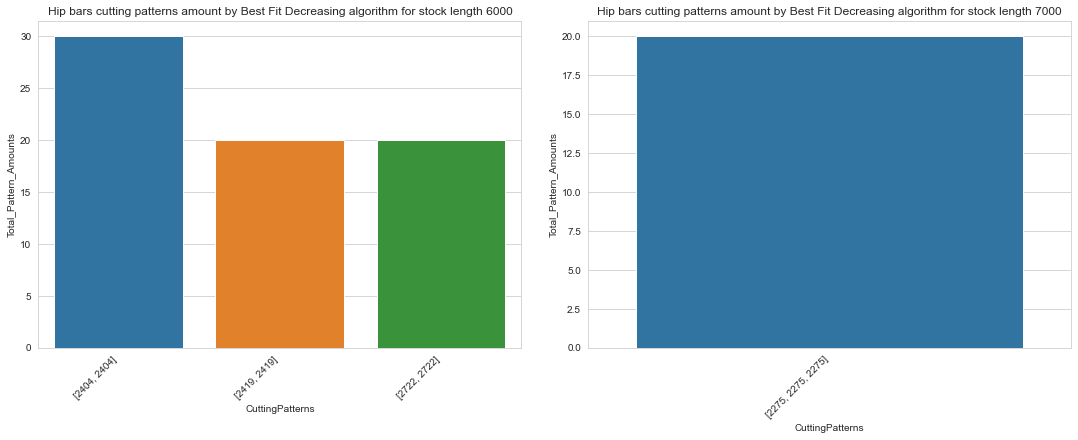

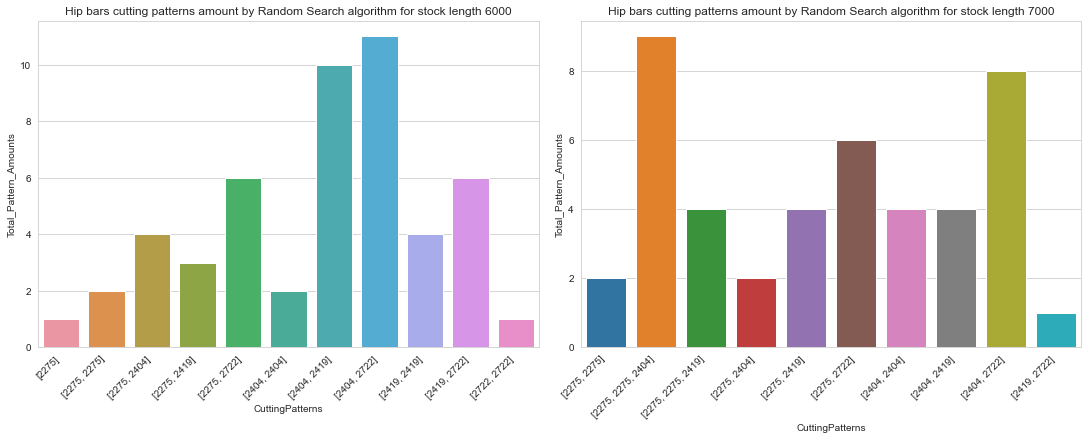

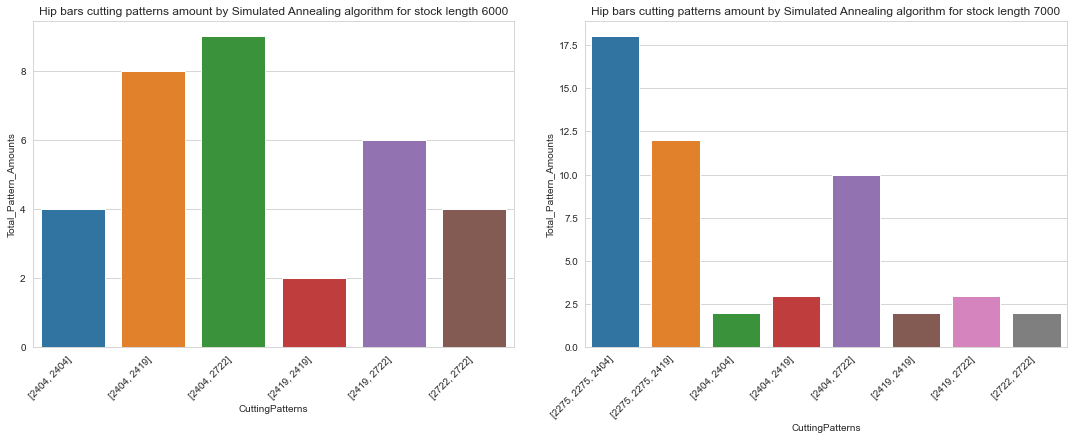

In [15]:
#Hip bar cutting patterns
for algorithm in algorithmList:
    newdf = pdf[(pdf['BarType']=='hip') & (pdf['Algorithm'] == algorithm) & (pdf['Seed']==14)][['StockLength','Total_Pattern_Amounts','CuttingPatterns']].reset_index(drop=True)
    fig = plt.figure(constrained_layout=True,figsize=(15,6))
    gs = GridSpec(1, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[0, -1])
    stocksChoice = sorted(list(newdf.StockLength.unique()))

    subdf_1 = newdf[newdf['StockLength'] == stocksChoice[0]].reset_index(drop = True)
    sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_1,ax=ax1)
    plt.setp(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax1.set_title('Hip bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[0]))
    
    subdf_2 = newdf[newdf['StockLength'] == stocksChoice[1]].reset_index(drop = True)
    sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_2,ax=ax2)
    plt.setp(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax2.set_title('Hip bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[1]))
    

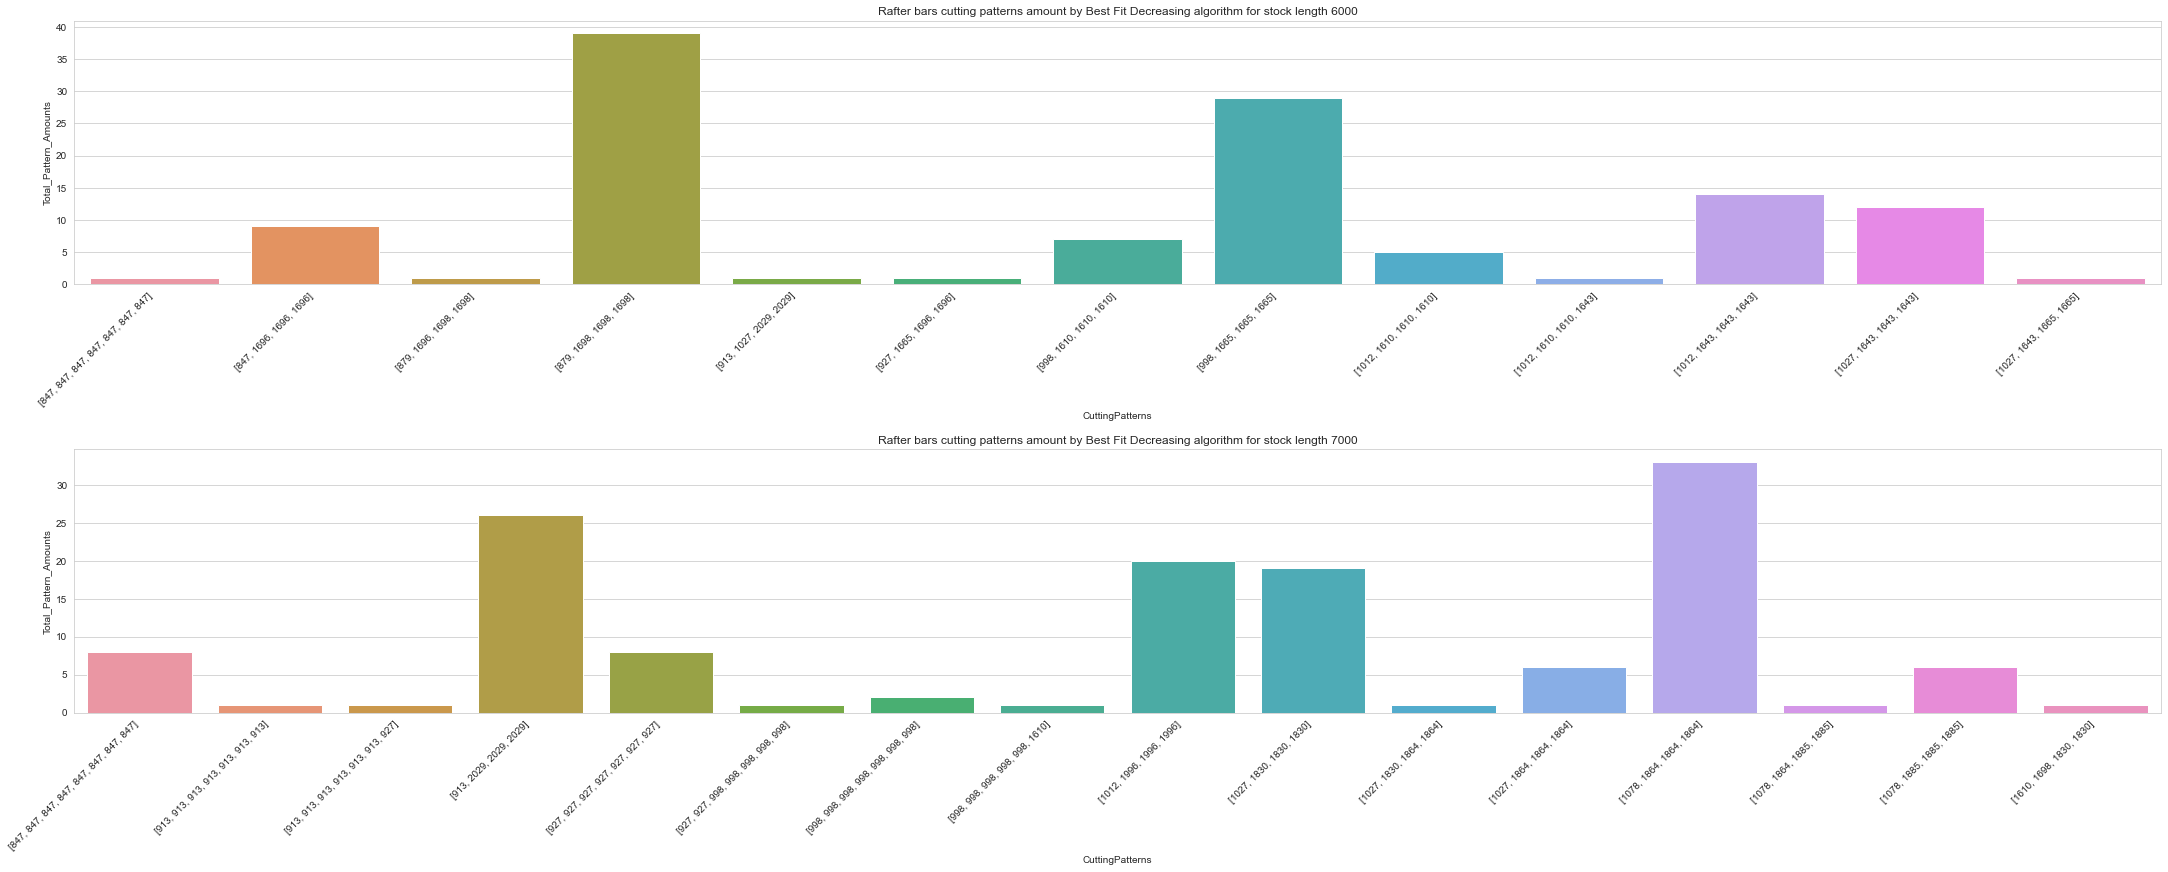

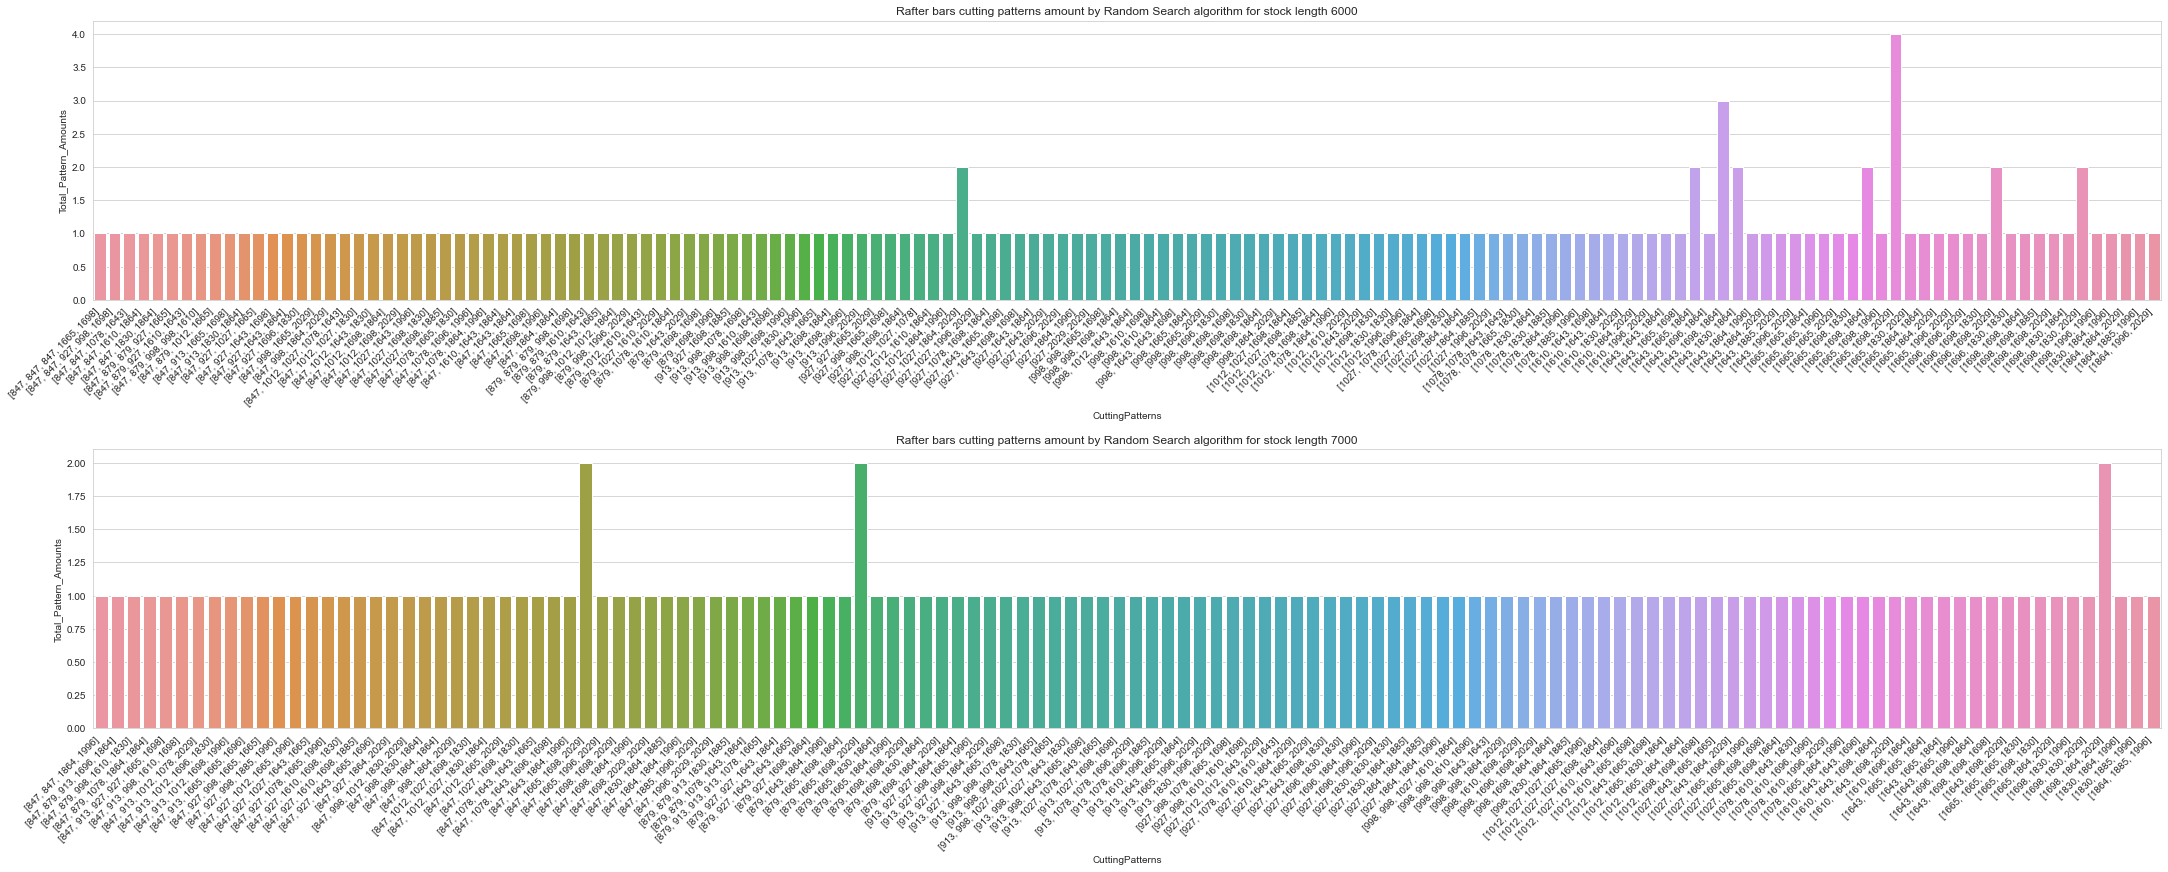

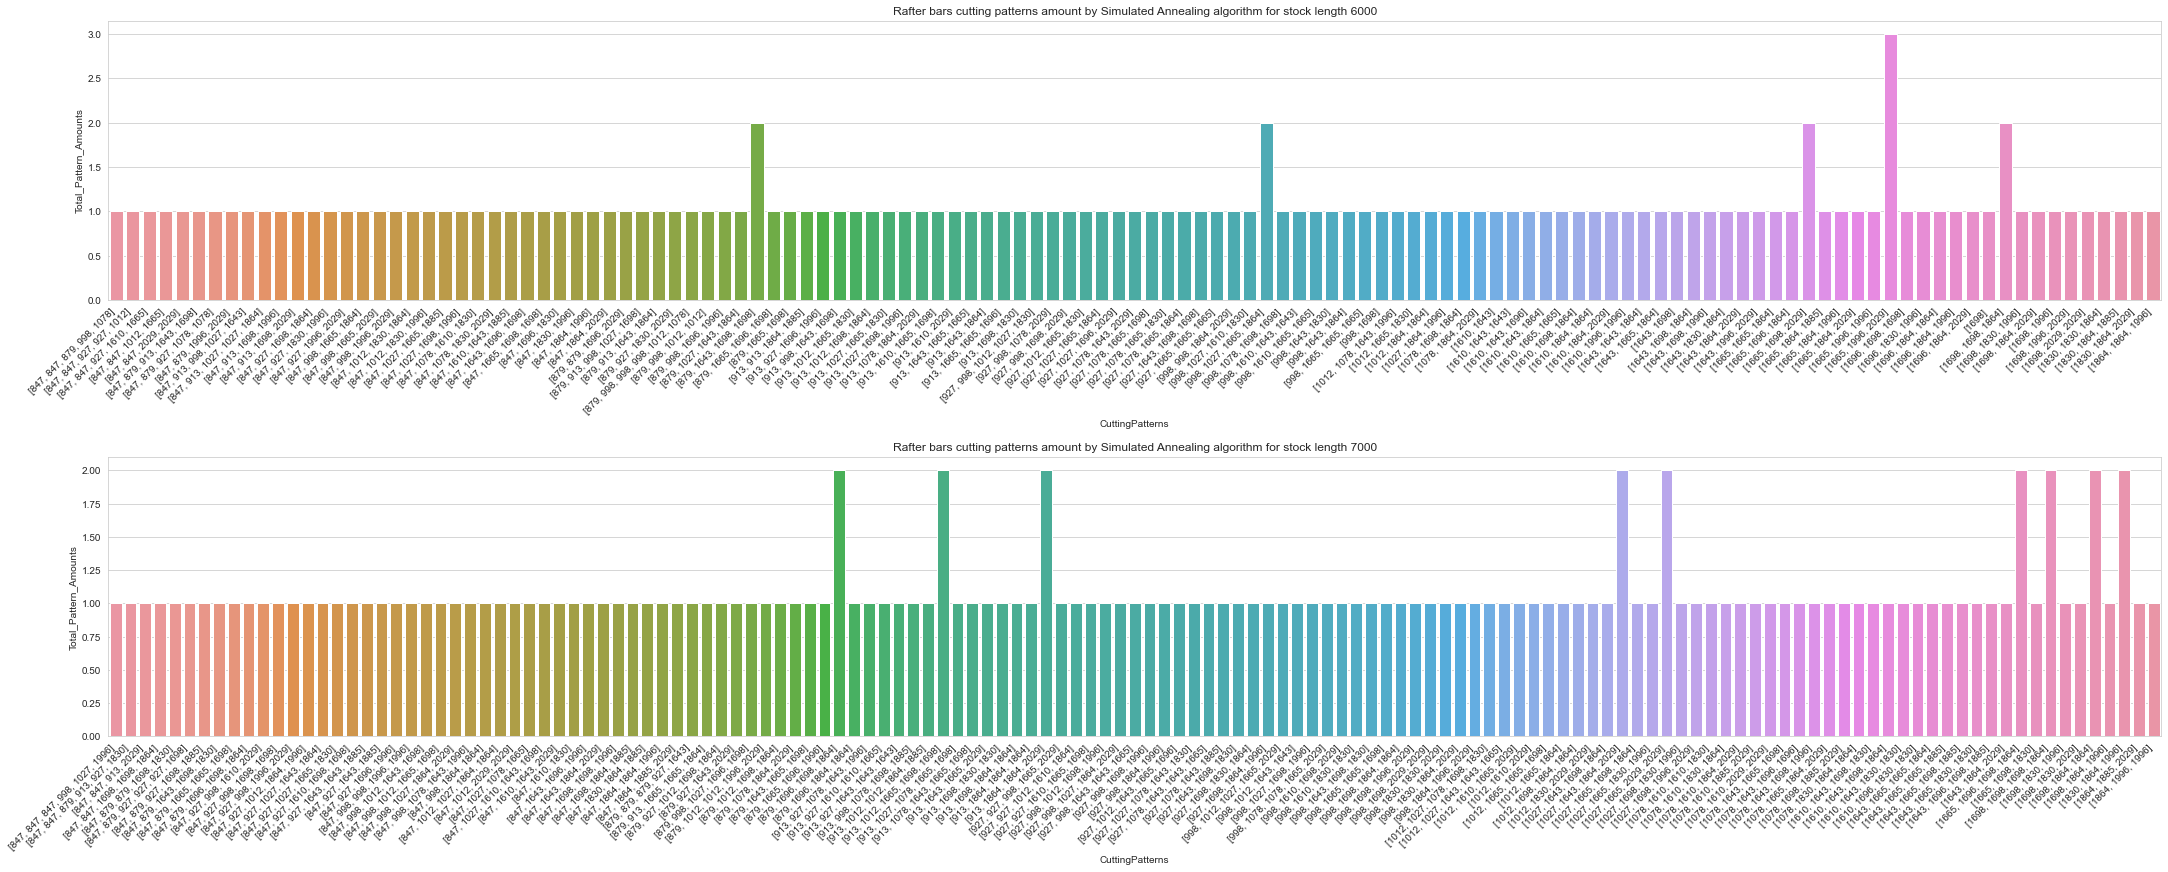

In [16]:
#Rafter bar cutting patterns
for algorithm in algorithmList:
    newdf = pdf[(pdf['BarType']=='rafter') & (pdf['Algorithm'] == algorithm) & (pdf['Seed']==10)][['StockLength','Total_Pattern_Amounts','CuttingPatterns']].reset_index(drop=True)
    fig = plt.figure(constrained_layout=True,figsize=(30,12))
    gs = GridSpec(2, 1, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    stocksChoice = sorted(list(newdf.StockLength.unique()))
    
    subdf_1 = newdf[newdf['StockLength'] == stocksChoice[0]].reset_index(drop = True)
    sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_1,ax=ax1)
    plt.setp(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax1.set_title('Rafter bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[0]))
    
    subdf_2 = newdf[newdf['StockLength'] == stocksChoice[1]].reset_index(drop = True)
    sns.barplot(x="CuttingPatterns",y="Total_Pattern_Amounts", data=subdf_2,ax=ax2)
    plt.setp(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax2.set_title('Rafter bars cutting patterns amount by '+ algorithm +' algorithm for stock length '+ str(stocksChoice[1]))
    

### Different order numbers
Order size increases from 10 to 100 sequentially

In [17]:
orders = pd.read_csv('orders_Results_RW.csv')
del orders['Unnamed: 0']
orders

,OrderAmount,BarType,Seed,Algorithm,Objective,Time_sec
0,10,ridge,0,Best Fit Decreasing,232.8,0.018015
1,10,ridge,0,Random Search,232.8,0.014583
2,10,ridge,0,Simulated Annealing,232.8,0.370636
3,10,ridge,1,Best Fit Decreasing,232.8,0.015769
4,10,ridge,1,Random Search,232.8,0.017159
...,...,...,...,...,...,...
1795,100,rafter,18,Random Search,65779.4,1.066425
1796,100,rafter,18,Simulated Annealing,67283.9,3.037078
1797,100,rafter,19,Best Fit Decreasing,13096.9,438.960176
1798,100,rafter,19,Random Search,63070.3,1.195121


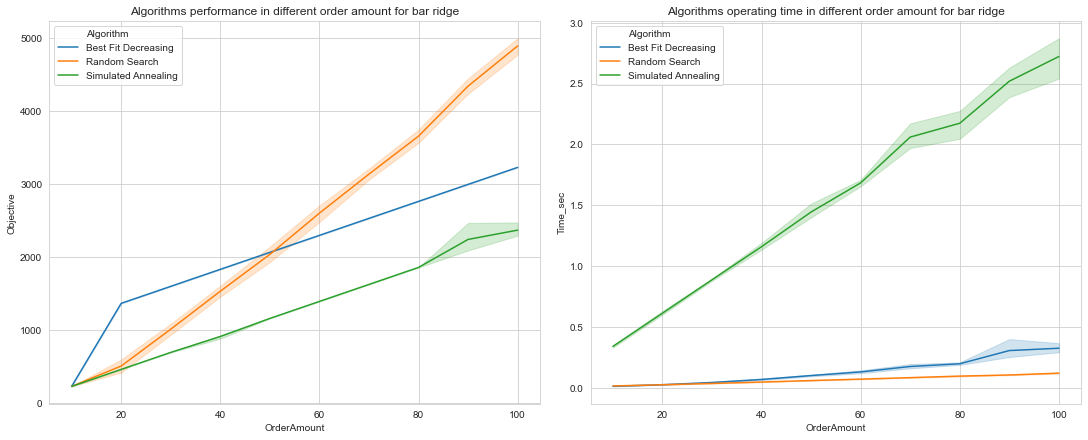

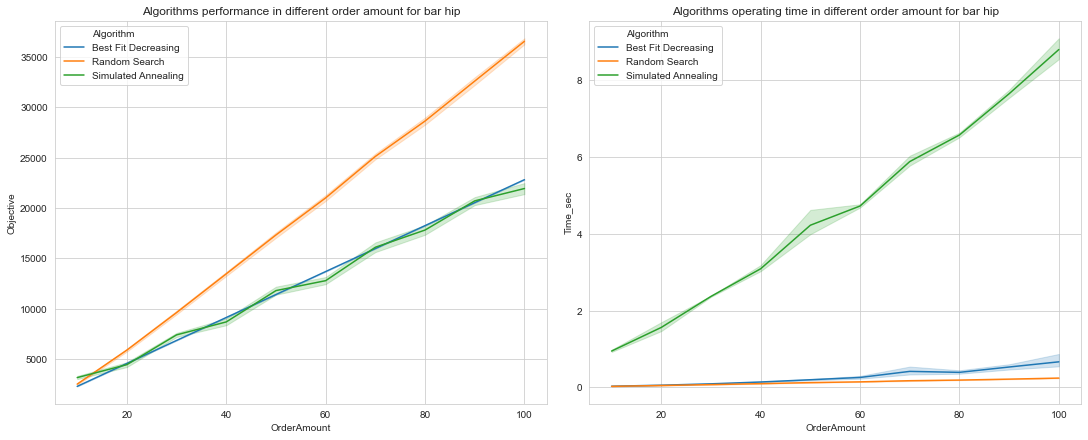

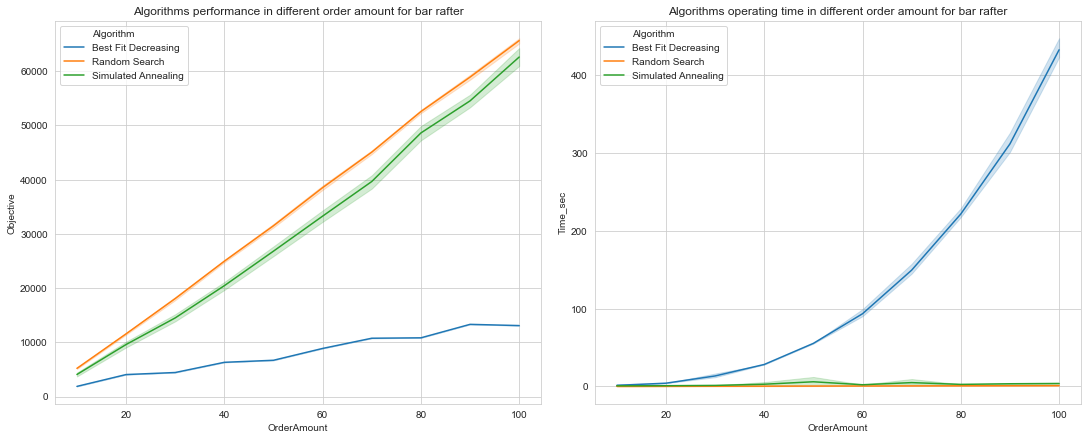

In [18]:
#plot the convergence situation and computational time of each algorithm on three subsets
def orders_plot(df):
    for barName in barList:
        fig = plt.figure(constrained_layout=True,figsize=(15,6))
        gs = GridSpec(1, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[0, -1])
        currDf = df[df['BarType'] == barName]
        sns.lineplot(x="OrderAmount", y="Objective", hue="Algorithm", data=currDf,ax=ax1)
        ax1.set_title('Algorithms performance in different order amount for bar '+barName)
        
        sns.lineplot(x="OrderAmount", y="Time_sec", hue="Algorithm", data=currDf,ax=ax2)
        ax2.set_title('Algorithms operating time in different order amount for bar '+barName)
        
        #plt.savefig('Different amounts of order')
        plt.show()
orders_plot(orders)

### Separate 100 orders into several scales

In [19]:
separate = pd.read_csv('separate_orders_Results_RW.csv')
del separate['Unnamed: 0']
separate

,BarType,Seed,Algorithm,OrderScale,Objective,Time_sec,Results
0,ridge,0,Best Fit Decreasing,100x1,3232.9,0.434891,"{0: [5000, 24, [1750, 1750, 1500], 0], 1: [500..."
1,ridge,0,Random Search,100x1,5346.6,0.146184,"{0: [5000, 24, [1750, 1500, 1500], 250], 1: [5..."
2,ridge,0,Simulated Annealing,100x1,2328.0,1.355923,"{0: [5000, 24, [1750, 1750, 1500], 0], 1: [500..."
3,ridge,0,Best Fit Decreasing,50x2,3835.6,0.199657,"{0: [5000, 24, [1750, 1750, 1500], 0], 1: [500..."
4,ridge,0,Random Search,50x2,3840.7,0.118874,"{0: [3000, 15, [1500, 1500], 0], 1: [5000, 24,..."
...,...,...,...,...,...,...,...
895,rafter,19,Random Search,20x5,55243.9,1.058785,"{0: [7000, 23, [1698, 1864, 1027, 1864], 547],..."
896,rafter,19,Simulated Annealing,20x5,45007.3,5.210090,"{0: [6000, 20, [998, 1885, 1012, 1698], 407], ..."
897,rafter,19,Best Fit Decreasing,10x10,18517.1,7.023932,"{0: [7000, 23, [2029, 2029, 2029, 913], 0], 1:..."
898,rafter,19,Random Search,10x10,50727.4,1.063230,"{0: [6000, 20, [1698, 913, 1830], 1559], 1: [7..."


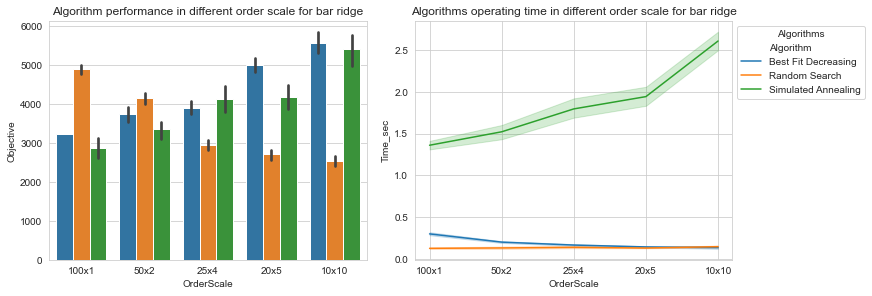

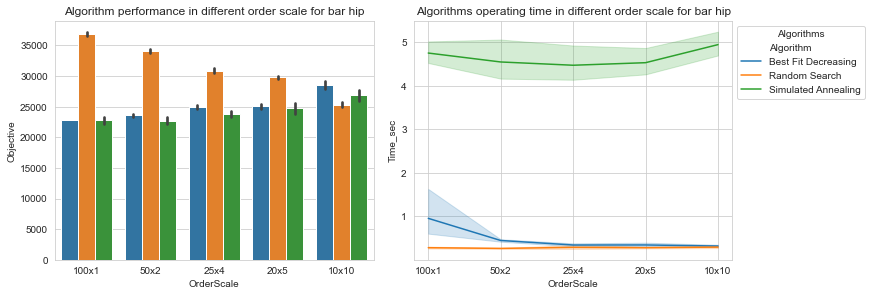

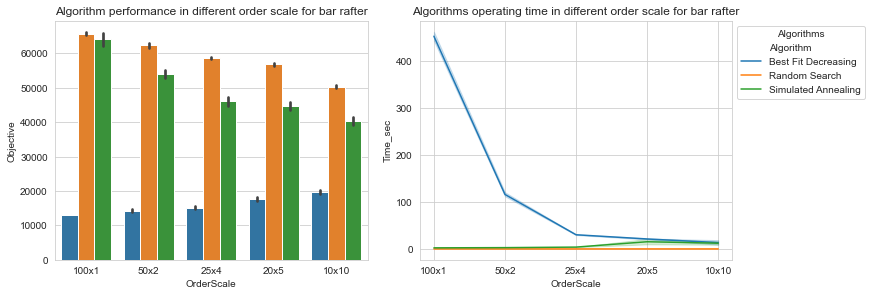

In [20]:
#plot the convergence situation and computational time of each algorithm when the order scale is different
def separate_orders_plot(df):
    for barName in barList:
        fig = plt.figure(constrained_layout=True,figsize=(12,4))
        gs = GridSpec(1, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[0, -1])
        currDf = df[df['BarType'] == barName]
        sns.barplot(x="OrderScale", y="Objective", hue="Algorithm",data=currDf, ax = ax1)

        ax1.set_title('Algorithm performance in different order scale for bar '+barName)
        ax1.legend_.remove()
        sns.lineplot(x="OrderScale", y="Time_sec", hue="Algorithm", data=currDf,ax=ax2,sort=False)
        ax2.set_title('Algorithms operating time in different order scale for bar '+barName)
        ax2.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),title = 'Algorithms')

separate_orders_plot(separate)